# Analyzing a proposal for NJ districting

This notebook provides an interactive plot demonstrating the likely partisan performance of a map drawn according to the rules laid out in [SCR43](https://www.njleg.state.nj.us/2018/Bills/SCR/43_I1.PDF).

The relevant text is as follow, with particularly relevant bits bolded:

>c. The Commission shall only certify a plan to establish legislative districts that ensures fair representation such that **each of the two major political parties has an equal number of districts more favorable to that party**. A District shall be more favorable to a political party if the percentage of total votes received in that district in all Statewide general elections by that party over the preceding decade of the offices of United States President, United States Senator, and Governor exceeds the percentage of total votes that party received in the average district in the plan, weighting each district equally.
>
>d. The Commission shall only certify a plan to establish legislative districts that ensures that **at least 25 percent of all districts are competitive districts, which shall mean a district that is more favorable to either major political party by no more than five percentage points of the average district in the plan. For each competitive district in which the percentage of total votes for a major political party exceeds that party’s percentage of total votes in the average district, there shall be a corresponding district in which that party’s percentage of total votes is less than the major party’s percentage of total votes in the average district by approximately the same percentage.**

To summarize, the above text requires that a map be drawn such that:
1. 50% of districts have a Dem voteshare above the historical statewide average, and 50% have Dem vote share below.
2. At least 25% of districts are "competitive," i.e., have a Dem voteshare within 5 percentage points of the historical statewide average
3. These "competitive" districts must have D voteshares that are roughly symmetrically distributed around the historical statewide average.

## Hit the "Run" button twice at the top and scroll down to play with the interactive!

In [90]:
import numpy as np
import gerrymetrics as g
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg'
import ipywidgets as wdgt

avgcolor = 'forestgreen'
curvecolor = 'red'

def make_plot(avg=.55, comp_prop=.25, comp_range=.05, N=4000, use_percents=True, show_hist=True, alt_competitiveness=False):

    N_comp = round(N*comp_prop)
    N_noncomp = N-N_comp
    
    if alt_competitiveness:
        comp_votes_hi = np.random.rand(round(N_comp/2))*comp_range + .5
        comp_votes_lo = -comp_votes_hi + 1

        other_votes_hi = np.random.rand(round((N_noncomp)/2))*(.5-comp_range) + .5 + comp_range
        
        current_average = np.mean(np.concatenate((comp_votes_hi, comp_votes_lo, other_votes_hi)))
        target_average = (2*avg - (1+comp_prop)*current_average) / (1-comp_prop)
        min_range = min(.5-comp_range-target_average, target_average)
        other_votes_lo_A = np.random.rand(round((N_noncomp)/4))*min_range+target_average-min_range
        other_votes_lo_B = -other_votes_lo_A + 2*target_average
        other_votes_lo = np.concatenate((other_votes_lo_A, other_votes_lo_B))
    else:
        comp_votes_hi = np.random.rand(round(N_comp/2))*comp_range + avg
        comp_votes_lo = -comp_votes_hi + 2*avg

        other_votes_hi = np.random.rand(round((N_noncomp)/2))*(1-avg-comp_range) + avg + comp_range

        other_votes_lo = -other_votes_hi + 2*avg
        

    Dvotes = np.concatenate((comp_votes_hi, comp_votes_lo, other_votes_hi, other_votes_lo))

    fig, ax = g.plot_seats_votes_curve(Dvotes)
    fig.set_size_inches(6, 6)
    n_D_seats = sum(Dvotes>.5)
    plt.scatter(avg, n_D_seats, marker='o', facecolors='none', linewidth=3, s=200, label='number of seats given an average voteshare', color='forestgreen', zorder=100)
    plt.scatter(.5, N/2, label='point at which partisan bias=0 and mean-median=0', color=curvecolor)
    plt.axvline(avg, label='average vote', color=avgcolor)
    if show_hist:
        ax.hist(Dvotes, bins=50, label='election histogram', color='mediumpurple')

    plt.legend(loc='upper left')
    plt.ylim([0, N])
    plt.xlim([0, 1])
    if use_percents:
        ax.set_xticklabels([f'{i:.0f}%' for i in np.linspace(0,100,11)])
        ax.set_xlabel('hypothetical Dem vote percentage')
        
        ax.set_yticks(np.linspace(0,1,11)*N)
        ax.set_yticklabels([f'{i:.0f}%' for i in np.linspace(0,100,11)])
        ax.set_ylabel('Dem seat percentage')


layout = wdgt.Layout(width='650px')
style = {'description_width': '300px'}
checklayout = wdgt.Layout(width='800px')
checkstyle = {'description_width': '50px'}

avg_widget = wdgt.FloatSlider(value=.55, min=0.0, max=1, step=0.01, description='average 2-party voteshare', continuous_update=False, style=style, layout=layout)
avg_widget.style.handle_color = avgcolor
N_widget = wdgt.IntSlider(value=4000, min=40, max=10000, step=10, description='# of districts (high for clarity, low for realism)', continuous_update=False, style=style, layout=layout)
comp_prop_widget = wdgt.FloatSlider(value=.25, min=0.0, max=1, step=0.01, description='proportion of districts that are competitive', continuous_update=False, style=style, layout=layout)
comp_range_widget = wdgt.FloatSlider(value=.05, min=0.0, max=0.4, step=0.01, description='competitiveness is defined as the average ± this:', continuous_update=False, style=style, layout=layout)
hist_widget = wdgt.Checkbox(value=False, description='show vote histogram', layout=checklayout, style=checkstyle)
perc_widget = wdgt.Checkbox(value=True, description='use percentages', layout=checklayout, style=checkstyle)
alt_comp_widget = wdgt.Checkbox(value=False, description='define competitiveness as being around 50% rather than around the average', layout=checklayout, style=checkstyle)

interactive_plot = wdgt.interactive(make_plot,
                                    avg=avg_widget,
                                    N=N_widget,
                                    comp_prop=comp_prop_widget,
                                    comp_range=comp_range_widget,
                                    show_hist=hist_widget,
                                    use_percents=perc_widget,
                                    alt_competitiveness=alt_comp_widget)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(FloatSlider(value=0.55, continuous_update=False, description='average 2-party voteshare'…

## Effects of requiring _at least_ 25 percent of all districts to be competitive

The above plot allows you to play with the parameters of the bill language to see the resulting seats-votes curve, and the percentage of seats that Dems could expect to win given some average voteshare. The critical thing to note is that the bill requires that *at least* 25% of all districts are "competitive," according to the above definition. If you keep most settings above at default, but increase the "proportion of districts that are competitive" slider, the seats-votes curve gets steeper.

Under a steeper seats-votes curve, Democrats gain an increased number of seats if they continue to win above 50% of the vote. The other effect of a steeper seats-votes curve is that in a GOP-favoring year, many seats will swing to the GOP. Simulate this possibility by adjusting the "average 2-party voteshare" slider.

## Historical average D voteshare
he Commission shall only certify a plan to establish legislative districts that ensures fair representation such that each of the two major political parties has an equal number of districts more favorable to that party. A District shall be more favorable to a political party if the percentage of total votes received in that district in all Statewide general elections by that party over the preceding decade of the offices of United States President, United States Senator, and Governor exceeds the percentage of total votes that party received in the average district in the plan, weighting each district equally.
The bill requires that you use, as a historical average voteshare, the average of all statewide general elections in the prior decade. We took the average of all NJ statewide general elections since 2011, which includes the following elections. The average comes out to .55.
- 2012 President: .59
- 2012 Senator: .599
- 2013 Governor: .388
- 2013 Senator (special): .555
- 2014 Senator: .569
- 2016 President: .573
- 2017 Governor: .572

## Effects of the definition of "favorable"

There is another problem with the bill, which is likely an unintended error in the drafting.

The bill defines an election in a district as being favorable to a party if it is higher than the statewide average _for that party_. However, it is probably intended to instead say _for that party as a proportion of all votes for the two major parties_. As it is currently written, a district may be more favorable for each of the major parties simultaneously, which would confuse the process of drawing districts as the bill requires. For instance, the average D vote as a fraction of all votes, including 3rd-parties, is 55%. The average R vote as a fraction of all votes is 43%. Therefore, a district could be drawn that yields a historical average D voteshare of 56% and a historical average R voteshare of 44%, which would be simultaneously favorable to both parties, and the symmetry construction in section (d) would be very bizarre to apply.

The simple fix is to make something like the following changes to (c):

>A District shall be more favorable to a political party if the ~~percentage~~ **number** of total votes received in that district in all Statewide general elections by that party, **divided by the total number of votes received by both major parties,** over the preceding decade of the offices of United States President, United States Senator, and Governor exceeds the ~~percentage~~ **number** of total votes that party received in the average district in the plan, **divided by the total number of votes received by both major parties,** weighting each district equally.

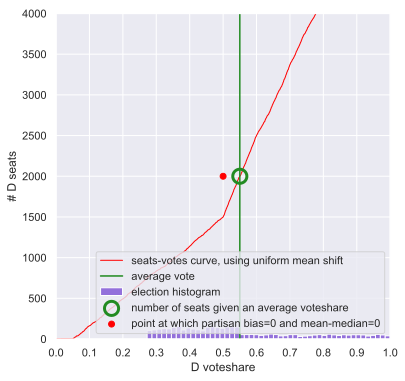

In [36]:
avgcolor = 'forestgreen'
curvecolor = 'red'

avg=.55
comp_prop=.25
comp_range=.05
N=4000
use_percents=False
show_hist=True    

N_comp = round(N*comp_prop)

comp_votes_hi = np.random.rand(round(N_comp/2))*comp_range + .5
comp_votes_lo = -comp_votes_hi + 1

other_votes_hi = np.random.rand(round((N-N_comp)/2))*(.5-comp_range) + .5 + comp_range

current_average = np.mean(np.concatenate((comp_votes_hi, comp_votes_lo, other_votes_hi)))
target_average = (2*avg - (1+comp_prop)*current_average) / (1-comp_prop)
min_range = min(.5-comp_range-target_average, target_average)
other_votes_lo_A = np.random.rand(round((N-N_comp)/4))*min_range+target_average-min_range
other_votes_lo_B = -other_votes_lo_A + 2*target_average


Dvotes = np.concatenate((comp_votes_hi, comp_votes_lo, other_votes_hi, other_votes_lo_A, other_votes_lo_B))

fig, ax = g.plot_seats_votes_curve(Dvotes)
fig.set_size_inches(6, 6)
n_D_seats = sum(Dvotes>.5)
plt.scatter(avg, n_D_seats, marker='o', facecolors='none', linewidth=3, s=200, label='number of seats given an average voteshare', color='forestgreen', zorder=100)
plt.scatter(.5, N/2, label='point at which partisan bias=0 and mean-median=0', color=curvecolor)
plt.axvline(avg, label='average vote', color=avgcolor)
if show_hist:
    ax.hist(Dvotes, bins=50, label='election histogram', color='mediumpurple')

plt.legend()
plt.ylim([0, N])
plt.xlim([0, 1])
if use_percents:
    ax.set_xticklabels([f'{i:.0f}%' for i in np.linspace(0,100,11)])
    ax.set_xlabel('hypothetical Dem vote percentage')

    ax.set_yticks(np.linspace(0,1,11)*N)
    ax.set_yticklabels([f'{i:.0f}%' for i in np.linspace(0,100,11)])
    ax.set_ylabel('Dem seat percentage')


In [37]:
target_average

0.3612261704137512

In [38]:
Dvotes.mean()

0.55

In [32]:
other_votes_lo_B

array([0.40926033, 0.42586456, 0.41161587, 0.43052429, 0.43877398,
       0.41824063, 0.40991921, 0.4080895 ])

In [31]:
other_votes_lo_A

array([0.40304897, 0.38644474, 0.40069343, 0.38178501, 0.37353532,
       0.39406868, 0.40239009, 0.4042198 ])

In [14]:
avg = (1+comp_prop)/2 * current_average + (1-comp_prop)*new_target/2

0.55

In [15]:
current_average = np.mean(np.concatenate((comp_votes_hi, comp_votes_lo, other_votes_hi)))
(2*avg - (1+comp_prop)*current_average) / (1-comp_prop)

0.33640053807351383

In [ ]:
new_target = (2*avg - (1+comp_prop)*current_average) / (1-comp_prop)

In [11]:
np.mean(np.concatenate((comp_votes_hi, comp_votes_lo, other_votes_hi)))

0.6781596771558918

In [13]:
(1-comp_prop)/2, (1+comp_prop)/2

0.375

In [19]:
np.max((1,2,3))

3